# Creating Helper Functions

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN('table', 'view');
'''

def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q,conn)
    
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
        
def show_tables():
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


# Selecting Albums to Purchase

In [3]:
albums_to_purchase = '''
      WITH usa_sold AS
          (
           SELECT il.* FROM invoice_line il
           INNER JOIN invoice i ON i.invoice_id = il.invoice_id
           INNER JOIN customer c ON c.customer_id = i.customer_id
           WHERE c.country = 'USA'       
          )
      SELECT
          g.name Genre_Name,
          COUNT(us.invoice_line_id) tracks_sold,
          (CAST(COUNT(us.invoice_line_id) as FLOAT) / ( SELECT COUNT(*) FROM usa_sold
          ) * 100) tracks_sold_percent
      FROM usa_sold us
      INNER JOIN track t ON t.track_id = us.track_id
      INNER JOIN genre g ON g.genre_id = t.genre_id
      GROUP BY 1
      ORDER BY 2 DESC LIMIT 10;
'''
run_query(albums_to_purchase)

,Genre_Name,tracks_sold,tracks_sold_percent
0,Rock,561,53.377735
1,Alternative & Punk,130,12.369172
2,Metal,124,11.798287
3,R&B/Soul,53,5.042816
4,Blues,36,3.425309
5,Alternative,35,3.330162
6,Latin,22,2.093245
7,Pop,22,2.093245
8,Hip Hop/Rap,20,1.902950
9,Jazz,14,1.332065


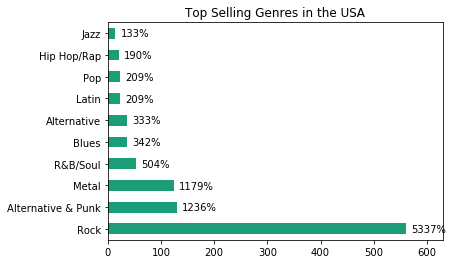

In [4]:
atp = run_query(albums_to_purchase)
atp.set_index('Genre_Name', drop=True, inplace=True)

atp['tracks_sold'].plot.barh(
    title='Top Selling Genres in the USA',
    xlim=(0,630),
    colormap=plt.cm.Dark2
)

plt.ylabel('')

for i, label in enumerate(list(atp.index)):
    score = atp.loc[label, 'tracks_sold']
    label = (atp.loc[label, 'tracks_sold_percent'] * 100).astype(int).astype(str) + '%'
    plt.annotate(label, (score + 10, i - 0.15))
   
plt.show()

We can clearly see that Rock genre makes up more than 50% of the entire sale in the USA. It is followed by Alternative&Punk and Metal, respetively, but the percentages are not siginificant. 

Let's say, we has just signed a deal with a new record label, and I've been tasked with selecting the first three albums that will be added to the store, from a list of four below. All four albums are by artists that don't have any tracks in the store right now -- have the artist names, and the genre of music they produce:

In [5]:
%%html
<style>
table {float:left}
</style>

| Artist Name | Genre   |
|:------|:------|
|   Reg  | Hip-Hop |
|   Blue Tone  | Punk |
|   Meteor and the Boys  | Pop |
|   BQS  | Blues |



Based on sales of tracks from each genre in the USA, we should purchase the new albums by the following artists:

-  Blue Tone(Punk)
-  BQS(Blues)
-  Meteor and the Boys(Pop)

Together, however, these three genres only makes up a few percentage of total sales. Therefore, we need to look out for any album from rock genre, which accounts for 53%.

# Analyzing Employee Sales Performance

In [6]:
employee_total_sales = '''
        WITH customer_total_sales AS
            (
             SELECT 
                 c.first_name || " " || c.last_name customer_name,
                 SUM(i.total) total_sales,
                 c.support_rep_id employee_id
             FROM customer c
             INNER JOIN invoice i ON i.customer_id = c.customer_id
             GROUP BY 1
            )

        SELECT
            e.first_name || " " || e.last_name employee_name,
            e.hire_date,
            SUM(cts.total_sales) employee_total_sales
        FROM customer_total_sales cts
        INNER JOIN employee e ON cts.employee_id = e.employee_id
        GROUP BY 1;
'''
run_query(employee_total_sales)

,employee_name,hire_date,employee_total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


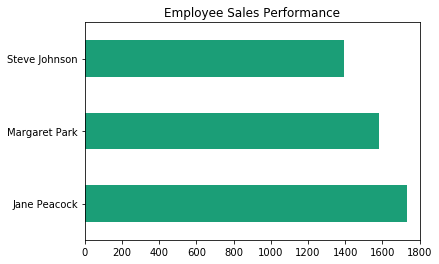

In [7]:
ets = run_query(employee_total_sales)
ets.set_index('employee_name', drop=True, inplace=True)

ets['employee_total_sales'].plot.barh(
    title = 'Employee Sales Performance',
    xlim = (0,1800),
    colormap = plt.cm.Dark2
)
ets.sort_values('employee_total_sales', inplace=True)
plt.ylabel('')

plt.show()

There were only 3 sales support agents at this companyto whom customers are assigned. The analysis above shows that the longer an agent has been working, the more sales performance he or she has.

# Analyzing Sales by Country

In [8]:
q = '''
WITH country_or_other AS
    (
        SELECT
            CASE
                WHEN (
                      SELECT COUNT(*)
                      FROM customer
                      WHERE country=c.country
                     ) = 1 THEN 'Other'
                ELSE c.country
            END AS country,
            c.customer_id,
            il.*
        FROM invoice_line il
        INNER JOIN invoice i ON i.invoice_id = il.invoice_id
        INNER JOIN customer c ON c.customer_id = i.customer_id
    )
SELECT
    country,
    number_of_customers,
    total_sales,
    average_order_value,
    average_value_of_sales_per_customer
FROM 
    (
    SELECT
        country,
        SUM(unit_price) total_sales,
        CASE
            WHEN country = 'Other' THEN 1
            ELSE 0
        END AS sort,
        COUNT(DISTINCT customer_id) number_of_customers,
        (SUM(unit_price) / COUNT(DISTINCT customer_id)) average_value_of_sales_per_customer,
        (SUM(unit_price) / COUNT(DISTINCT invoice_id)) average_order_value    
    FROM country_or_other
    GROUP BY 1
    ORDER BY sort ASC, total_sales DESC
    )


'''
run_query(q)

,country,number_of_customers,total_sales,average_order_value,average_value_of_sales_per_customer
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


# Albums vs Individual Tracks

In [9]:
q = '''
    WITH invoice_first_track AS
        (
         SELECT
             invoice_id,
             MIN(il.track_id) first_track_id,
             t.album_id
         FROM invoice_line il
         INNER JOIN track t ON t.track_id = il.track_id
         GROUP BY 1
        )   
        
    SELECT
        album_purchase,
        COUNT(invoice_id) number_of_invoices,
        CAST(COUNT(invoice_id) as FLOAT) / (SELECT COUNT(*) FROM invoice) percentage_of_invoices
    
    FROM
        (
         SELECT
              ift.*,
              CASE
                  WHEN (
                        (
                        SELECT track_id FROM track
                        WHERE album_id = (SELECT t2.album_id FROM track t2
                                          WHERE t2.track_id = ift.first_track_id
                                         )
                        EXCEPT
                        
                        SELECT track_id FROM invoice_line
                        WHERE invoice_id = ift.invoice_id
                        ) IS NULL
                        
                        AND
                        
                        (
                        SELECT track_id FROM invoice_line
                        WHERE invoice_id = ift.invoice_id
                        
                        EXCEPT
                        
                        SELECT track_id FROM track
                        WHERE album_id = (SELECT t2.album_id FROM track t2
                                          WHERE t2.track_id = ift.first_track_id
                                         )
                        ) IS NULL
                      ) THEN 'yes'
                 ELSE 'no'
             END AS album_purchase
             
         FROM invoice_first_track ift
         )
    GROUP BY 1

'''
run_query(q)

,album_purchase,number_of_invoices,percentage_of_invoices
0,no,500,0.814332
1,yes,114,0.185668
